In [186]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *
import pandas as pd
from scipy import stats

In [102]:
def update_func(state, t, system, dvdt, unflipper, r_linear_function, slope, intercept):
    """Update the thermal transfer model.
    
    State objects:
    Temperature of vessle
    Volume of vessle
    
    t --> time
    T --> Temperature
    
    returns: State object containing the stocks
    """
    unpack(system)
    
    T = state.T
    V = state.V

    r = unflipper(r_linear_function, slope, intercept, state.V)
    
    dTdt = -r * (T - T_env)
    # dvdt is passed in as an argument - it is being swept
    
    if(V>0 and T >25):
        T += dTdt * dt
        V += dvdt * dt
    else:
        V = 0
        T = None        
    
    return State(T=T, V=V)

In [103]:
def run_simulation(system, update_func, dvdt, unflipper, r_linear_function, slope, intercept):
    """Runs a simulation of the system.
    
    Add a TimeFrame to the System: results
    """
    unpack(system)
    
    frame = TimeFrame(columns=init.index)
    frame.row[0] = init
    ts = linrange(0, t_end, dt)
    
    for t in ts:
        frame.row[t+dt] = update_func(frame.row[t], t, system, dvdt, unflipper, r_linear_function, slope, intercept)
        
    # store the final temperature in T_final
    system.T_final = get_last_value(frame.T)
    
    return frame

In [104]:
# Done
def make_system(T_init, V_init, t_end, dvdt):
    """Makes a System object with the given parameters.

    T_init: initial temperature in degC
    r: heat transfer rate - when run, a function of r will be substituted in for it
    t_end: end time of simulation
    T_env: temperature of the environment
    dt: time step
    
    returns: System object
    """
    init = State(T=T_init, V=V_init)
    
    # T_final is used to store the final temperature.
    # Before the simulation runs, T_final = T_init
    # We do the same thing for Volume
    T_final = T_init
    V_final = V_init
    
    T_env = 25
    dt = 1
    
    
    
    return System(locals())


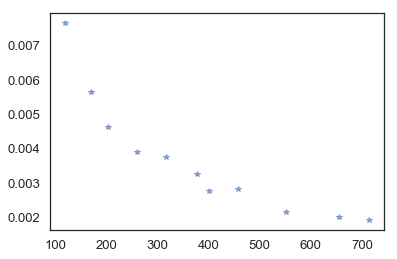

In [105]:
data = {'Volume': [118.354, 169.507,202.606,258.774,316.948,377.128,401.2,458.371,551.65,654.959,714.136,], 
             'r': [0.007660215,0.00563342,0.004614561,0.003912183,0.003744291,0.003259004,0.002769218,
                   0.002814454,0.002157224,0.001998175,0.001906878]}
r_vs_volume_data = pd.DataFrame(data=data)
plot(r_vs_volume_data['Volume'], r_vs_volume_data['r'], '*')

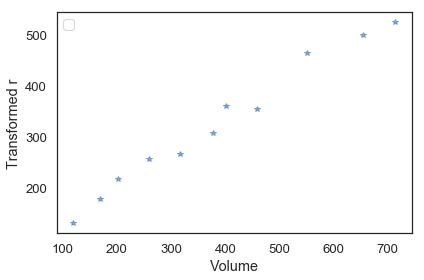

In [106]:
data2 = {'Volume': r_vs_volume_data['Volume'], 'Transformed r': 1 / r_vs_volume_data['r']}
r_vs_volume_transformed_data = pd.DataFrame(data=data2)
plot(r_vs_volume_transformed_data['Volume'], r_vs_volume_transformed_data['Transformed r'], '*')
decorate(xlabel = 'Volume', ylabel = 'Transformed r')


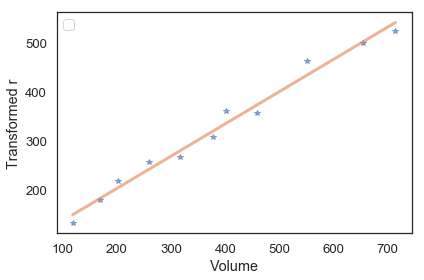

In [107]:
x = r_vs_volume_transformed_data['Volume']
y = r_vs_volume_transformed_data['Transformed r']
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)


def r_linear_function(slope, intercept, volume):
    r = slope * volume + intercept
    return r
r_plot = r_linear_function(slope, intercept, r_vs_volume_transformed_data['Volume'])

def plot_linear_on_data():
    plot(r_vs_volume_transformed_data['Volume'], r_vs_volume_transformed_data['Transformed r'], '*')
    decorate(xlabel = 'Volume', ylabel = 'Transformed r')
    plot(r_vs_volume_transformed_data['Volume'], r_plot)

plot_linear_on_data()

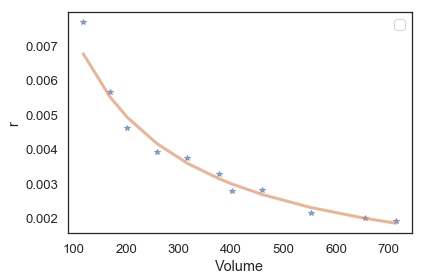

In [108]:
def unflipper(r_linear_function, slope, intercept, volume):
    r = r_linear_function(slope, intercept, volume) ** -1
    return r

r_nonlinear_function = unflipper(r_linear_function, slope, intercept, r_vs_volume_transformed_data['Volume'])

def plot_nonlinear_on_data():
    plot(r_vs_volume_data['Volume'], r_vs_volume_data['r'], '*')
    decorate(xlabel = 'Volume', ylabel = 'r')
    plot(r_vs_volume_data['Volume'], r_nonlinear_function)

plot_nonlinear_on_data()

In [121]:
system = make_system(85, 700, 300, -1)
'''
frame_thing = run_simulation(system, update_func, -2.3333, unflipper, r_linear_function, slope, intercept)
frame_thing2 = run_simulation(system, update_func, -1, unflipper, r_linear_function, slope, intercept)
#plot(frame_thing.index, frame_thing['V'])

plot(frame_thing.index, frame_thing['T'])
plot(frame_thing2.index, frame_thing2['T'])
decorate(legend = True, title = '')
'''

"\nplot(frame_thing.index, frame_thing['T'])\nplot(frame_thing2.index, frame_thing2['T'])\ndecorate(legend = True, title = '')\n"

In [158]:
def sweepdVdt(system):
    sweep = SweepSeries()
    dvdt_range = linspace(-5,0,10)
    
    for t in range(0,10):
        dvdt = dvdt_range[t]
        sweep[t] = run_simulation(system, update_func, dvdt, unflipper, r_linear_function, slope, intercept)
    return sweep    
    

In [160]:
swept = sweepdVdt(system)

NameError: name 'sweep' is not defined

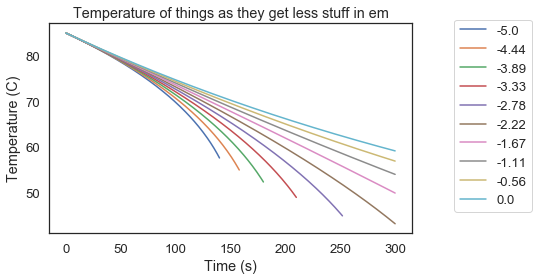

In [206]:
dvdt_range = linspace(-5,0,10)
fig = plt.figure()
ax = plt.subplot(111);
for i in range(10):
    #dvdt = dvdt_range_round[i]
    
    dvdt = round(dvdt_range[i], 2)
    ax.plot(swept[i].index, swept[i].T, label = dvdt)
    decorate(xlabel = 'Time (s)',
            ylabel = 'Temperature (C)',
            title = 'Temperature of things as they get less stuff in em')
    ax.legend(bbox_to_anchor=(1.1,1.05))
#print(dvdt_range_round)


In [197]:
help(decorate)

Help on function decorate in module modsim:

decorate(**options)
    Decorate the current axes.
    
    Call decorate with keyword arguments like
    
    decorate(title='Title',
             xlabel='x',
             ylabel='y')
    
    The keyword arguments can be any of the axis properties
    
    https://matplotlib.org/api/axes_api.html
    
    In addition, you can use `legend=False` to suppress the legend.
    
    And you can use `loc` to indicate the location of the legend
    (the default value is 'best')

